In [158]:
%pylab inline
%config InlineBackend.figure_format = 'svg'
%load_ext autoreload
%autoreload 2
import numpy as np
import scipy as sp
from tqdm import tqdm
import os
import sys, glob
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from data_helper import *
sns.set_context({'figure.figsize': [10, 6]})
sns.set_context(rc={'lines.markeredgewidth': 0.1})
sns.set_style('white')
sns.set_color_codes()
matplotlib.rc('xtick', labelsize=10) 
matplotlib.rc('ytick', labelsize=10) 

Populating the interactive namespace from numpy and matplotlib
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Outline
* Dataset overview 
* TFIDF and topic analysis
* Cluster startups to 6 areas based on topic feature
* Explore the trend of startups in each area
* A simple recommendation engine based nearest neighbor

# Data Set Overview

## Crunch base company info 
Dataset is aquired through Crunchbase Pro subscription and manual CSV download. We only looked at the startups under the Category `Data and Analytics`

In [2]:
cb_data = pd.read_csv('crunchbase_data/overall_company_list.csv', index_col=0)
# cb_data = cb_data.drop_duplicates(subset=['Company Name', 'Website'])
cb_data = cb_data.drop_duplicates(subset=['Company Name'])
cb_data.year = cb_data.year.astype(int)
cb_data = cb_data.rename(columns={'year': 'Founded Year'})
print(cb_data.shape)
cb_data.head()

(8350, 28)


,Company Name,Category Groups,Headquarters Location,Description,Crunchbase Rank,Founded Date,Number of Articles,Total Equity Funding Amount,Total Funding Amount,Closed Date,...,IPO Date,Money Raised at IPO,Valuation at IPO,Stock Symbol,Stock Exchange,Trend Score (7 Days),Trend Score (30 Days),Trend Score (90 Days),Website,Founded Year
0,Krux,"Media and Entertainment, Data and Analytics, S...","San Francisco, California, United States","Krux helps marketers, publishers and agencies ...",35,2010-01-01,91,"$50,000,000","$50,000,000",NaN,...,NaN,NaN,NaN,NaN,NaN,7.4,9.4,9.6,http://www.krux.com,2010
1,Datadog,"Information Technology, Data and Analytics, So...","New York, New York, United States",Datadog is the essential monitoring service fo...,374,2010-01-01,95,"$147,900,000","$147,900,000",NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,-0.5,-1.3,http://datadog.com,2010
2,Sumo Logic,"Data and Analytics, Software","Redwood City, California, United States","Sumo Logic, a log management and analytics ser...",407,2010-01-01,128,"$155,000,000","$155,000,000",NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,-1.2,0.6,http://www.sumologic.com,2010
3,Quid,"Information Technology, Data and Analytics, So...","San Francisco, California, United States",Quid powers human intuition with machine intel...,709,2010-01-01,44,"$66,500,000","$66,500,000",NaN,...,NaN,NaN,NaN,NaN,NaN,-0.2,-0.2,2.5,http://quid.com,2010
4,Vicarious,"Media and Entertainment, Data and Analytics, S...","San Francisco, California, United States",Vicarious develops Recursive Cortical Network™...,718,2010-01-01,33,"$72,000,000","$72,000,000",NaN,...,NaN,NaN,NaN,NaN,NaN,-0.2,-0.2,-1.4,http://vicarious.com,2010


## Augment with google data
use google search to get a short description of each company, merge with the crunch base description

In [3]:
cb_data['google_text'] = ''

In [4]:
for index, row in tqdm(cb_data.iterrows(), total=cb_data.shape[0]):
    c = row['Company Name']
    fname = os.path.join('google_text', '{}_CB.txt'.format(c))
    fname_backup = os.path.join('google_text', '{}_CB.txt'.format(str(hash(c))))
    actual_fname = None
    #print(fname)
    if os.path.exists(fname):
        actual_fname = fname
    if os.path.exists(fname_backup):
        actual_fname = fname_backup

    if actual_fname is not None:
        with open(actual_fname, 'r') as f:
            text = f.readline()
        cb_data.loc[index, 'google_text'] = text
    else:
        #print('no text available for {}'.format(c))
        pass

100%|██████████| 8350/8350 [00:05<00:00, 1601.68it/s]


In [5]:
cb_data['google_description'] = cb_data['Description'] + cb_data['google_text']

In [6]:
print('-'*10,'Crunchbase Description','-'*10)
print(cb_data['Description'][0])
print('-'*10,'google search','-'*10)
print(cb_data['google_text'][0])
print('-'*10,'Merge','-'*10)
print(cb_data['google_description'][0])

---------- Crunchbase Description ----------
Krux helps marketers, publishers and agencies drive revenue by delivering smarter content, commerce and marketing experiences.
---------- google search ----------
Krux helps companies deliver personalized commerce, media, and marketing experiences to the right people, in the right way, at the right time across all devices ...
---------- Merge ----------
Krux helps marketers, publishers and agencies drive revenue by delivering smarter content, commerce and marketing experiences.Krux helps companies deliver personalized commerce, media, and marketing experiences to the right people, in the right way, at the right time across all devices ...


## Crunchbase acquisition info
Crunchbase put the acuisition info in seperate CSVs

In [7]:
acq_file_list = glob.glob('crunchbase_data/cb_acquisitions/*csv')
dfs = []
for f in acq_file_list:
    dfs.append(pd.read_csv(f))
acq_df = pd.concat(dfs, ignore_index=True)
acq_df = acq_df.drop_duplicates(subset=['Acquired Company Name'])

acq_df['Acquired Year'] = acq_df['Announced On Date'].apply(lambda x: int(x[-4:])) # extract year from date string

print(acq_df.shape)
acq_df.head()

(3729, 6)


,Transaction Name,Acquired Company Name,Acquiring Company Name,Announced On Date,Price,Acquired Year
0,Centric Health Corp. acquires CareRx,CareRx,Centric Health Corp.,09/22/2016,"$14,000,000",2016
1,Warburg Pincus acquires Ascentium Capital,Ascentium Capital,Warburg Pincus,10/04/2016,NaN,2016
2,Sharecare acquires BioLucid,BioLucid,Sharecare,09/29/2016,NaN,2016
3,Google acquires Api.ai,Api.ai,Google,09/19/2016,NaN,2016
4,Demand Media acquires The Other Art Fair,The Other Art Fair,Demand Media,09/16/2016,NaN,2016


merge the company info and acquisition

In [8]:
cb_data_merged = cb_data.merge(acq_df, how='left', left_on='Company Name', right_on='Acquired Company Name')

In [9]:
cb_data_merged.head()

,Company Name,Category Groups,Headquarters Location,Description,Crunchbase Rank,Founded Date,Number of Articles,Total Equity Funding Amount,Total Funding Amount,Closed Date,...,Website,Founded Year,google_text,google_description,Transaction Name,Acquired Company Name,Acquiring Company Name,Announced On Date,Price,Acquired Year
0,Krux,"Media and Entertainment, Data and Analytics, S...","San Francisco, California, United States","Krux helps marketers, publishers and agencies ...",35,2010-01-01,91,"$50,000,000","$50,000,000",NaN,...,http://www.krux.com,2010,Krux helps companies deliver personalized comm...,"Krux helps marketers, publishers and agencies ...",Salesforce acquires Krux,Krux,Salesforce,10/03/2016,"$700,000,000",2016.0
1,Datadog,"Information Technology, Data and Analytics, So...","New York, New York, United States",Datadog is the essential monitoring service fo...,374,2010-01-01,95,"$147,900,000","$147,900,000",NaN,...,http://datadog.com,2010,Datadog is the essential monitoring service fo...,Datadog is the essential monitoring service fo...,NaN,NaN,NaN,NaN,NaN,NaN
2,Sumo Logic,"Data and Analytics, Software","Redwood City, California, United States","Sumo Logic, a log management and analytics ser...",407,2010-01-01,128,"$155,000,000","$155,000,000",NaN,...,http://www.sumologic.com,2010,Sumo Logic is the next generation log manageme...,"Sumo Logic, a log management and analytics ser...",NaN,NaN,NaN,NaN,NaN,NaN
3,Quid,"Information Technology, Data and Analytics, So...","San Francisco, California, United States",Quid powers human intuition with machine intel...,709,2010-01-01,44,"$66,500,000","$66,500,000",NaN,...,http://quid.com,2010,Quid powers human intuition with machine intel...,Quid powers human intuition with machine intel...,NaN,NaN,NaN,NaN,NaN,NaN
4,Vicarious,"Media and Entertainment, Data and Analytics, S...","San Francisco, California, United States",Vicarious develops Recursive Cortical Network™...,718,2010-01-01,33,"$72,000,000","$72,000,000",NaN,...,http://vicarious.com,2010,Vicarious develops Recursive Cortical Network™...,Vicarious develops Recursive Cortical Network™...,NaN,NaN,NaN,NaN,NaN,NaN


# Topic analysis and clustering

In [10]:
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.preprocessing import normalize
from sklearn.manifold import TSNE
from sklearn.utils import resample

In [11]:
from nltk.corpus import stopwords
stop_list=stopwords.words('english')+['help','new', 'way', 'world', 'make', 'people']

In [13]:
cb_data_merged = cb_data_merged.dropna(subset=['google_description'])

TF-IDF features

In [14]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, min_df=2,
                                   max_features=3000,
                                   tokenizer=LemmaTokenizer(),
                                   stop_words=stop_list)
tfidf = tfidf_vectorizer.fit_transform(cb_data_merged['google_description'])

topic analysis with NMF (non-negative matrix factorization). Also tried LDA, but results not as good. 

In [34]:
nmf = NMF(n_components=15, random_state=1, 
          alpha=0.1, l1_ratio=0.5, max_iter=5000).fit(tfidf)
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
topic_feature=nmf.transform(tfidf)
topic_feature_norm=normalize(topic_feature)

Topic #0:
data big science visualization driven analysis insight enterprise platform source
Topic #1:
mobile application app user web apps enables allows share device
Topic #2:
platform customer online enables user content brand engagement video experience
Topic #3:
marketing digital agency advertising campaign automation sale firm brand marketer
Topic #4:
crunchbase update detail add touch employee click founded contact none
Topic #5:
social medium network content brand tool connect networking discovery community
Topic #6:
intelligence artificial ai human powered assistant competitive us virtual industry
Topic #7:
business small customer local tool intelligence sale process information offer
Topic #8:
real time estate insight information delivers analysis feedback tool track
Topic #9:
analytics predictive provides advanced retail tool saas insight sale performance
Topic #10:
solution service provides cloud offer provider management enterprise software product
Topic #11:
research marke

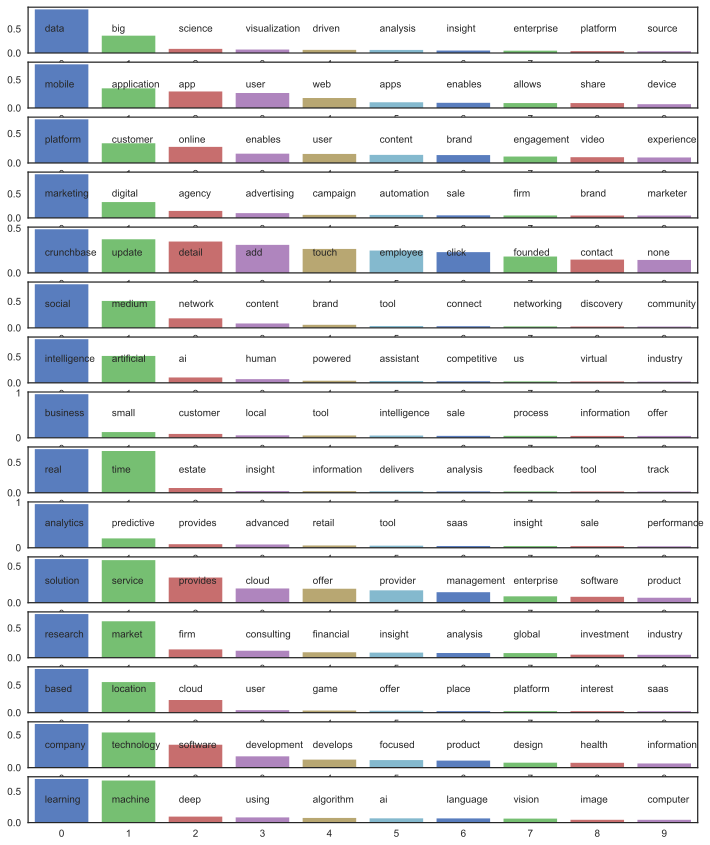

In [35]:
fig=figure(figsize=(12,15))
for i in range(15):
    subplot(15,1,i+1)
    plot_top_words(nmf,tfidf_feature_names,i)

Now each startup is a linear combination of topics. Let's call this topic feature. We can apply clustering on the topic features

In [17]:
from sklearn import metrics
from sklearn.metrics import pairwise_distances
from sklearn.cluster import KMeans

In [46]:
kmeans= KMeans(init='k-means++', n_clusters=6)
kmeans.fit(topic_feature_norm)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=6, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

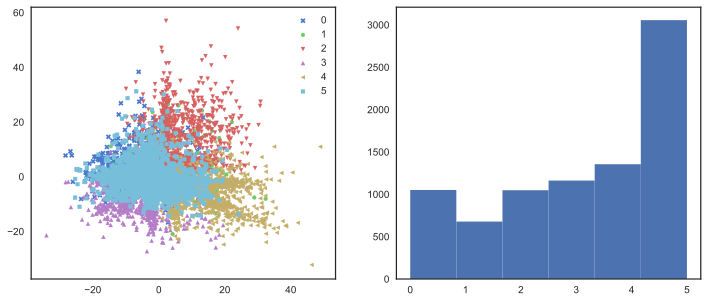

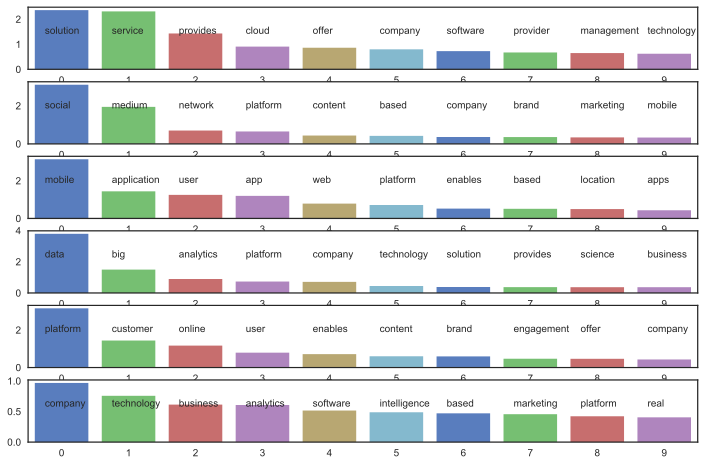

In [52]:
plot_cluster(kmeans, topic_feature_norm, topic_feature_norm, tfidf_feature_names, nmf)

In [ ]:
# save the cluster models

In [48]:
# save model
import pickle
save_model={'tfidf':tfidf, 
           'nmf':nmf,
           'topic_feature_norm': topic_feature_norm,
           'tfidf_feature_names': tfidf_feature_names,
           'cluster_model': kmeans}
with open('cluster_model_save.p','wb') as f:
    pickle.dump(save_model, f)

In [53]:
cluster_name={0: 'Cloud Service',
             1: 'Social Medium',
             2: 'Mobile App',
             3: 'Big Data Platform',
             4: 'Online Customer Service',
             5: 'Business Intelligence'}

In [54]:
# add labels to dataset
cb_data_merged_labeled = cb_data_merged
cb_data_merged_labeled['label'] = kmeans.labels_
cb_data_merged_labeled['label_name']=cb_data_merged_labeled['label'].apply(lambda label:cluster_name[label] )

look at sample startups in each area

In [62]:
print_cluster_member(cb_data_merged_labeled, 1, 5)

Class: Social Medium
number of companies in this class: 678
---------- Sample Startups ----------
company ID: 4
Vicarious develops Recursive Cortical Network™, a visual perception system that interprets the contents of photographs and videos.Vicarious develops Recursive Cortical Network™, a visual perception system that interprets the contents of photographs and videos.
company ID: 13
Flyby Media develops next-generation consumer mobile social applications that connect the physical world with digital content.Flyby Media develops next-generation consumer mobile social applications that connect the physical world with digital content.
company ID: 17
Simply Measured provides social media analytics and measurements for data-driven agencies and brands.Simply Measured provides social media analytics and measurements for data-driven agencies and brands.
company ID: 22
MyLikes is the World's Largest Social Website Network. MyLikes drives traffic to content by empowering publishers to monetize 

# Trends in each area

number of startups in each area. BI is most popular

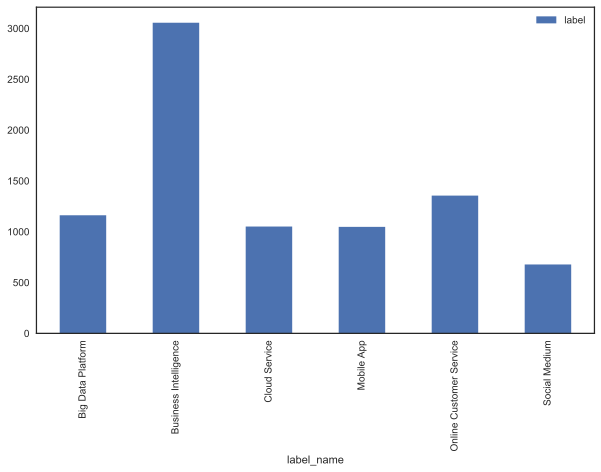

In [164]:
cb_data_merged_labeled.groupby('label_name').count().plot.bar(y='label')

startups founded in each year. 

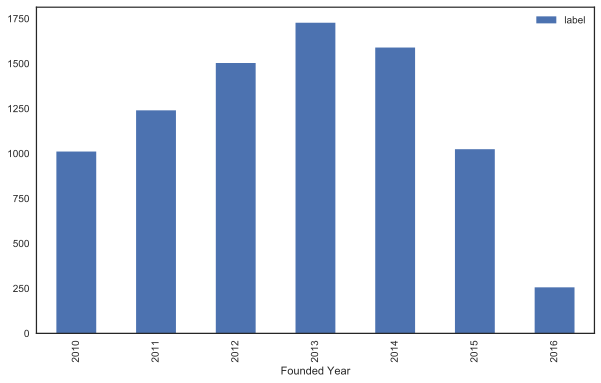

In [165]:
cb_data_merged_labeled.groupby('Founded Year').count().plot.bar(y='label')

In [84]:
sns.set_palette(sns.color_palette('deep'))

In [166]:
df = cb_data_merged_labeled.groupby(['Founded Year', 'label_name']).count()['Company Name'].unstack()

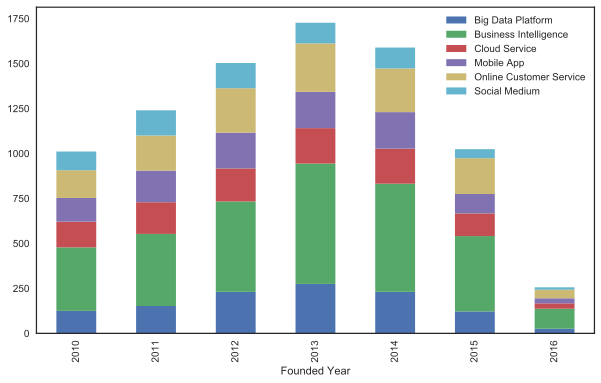

In [167]:
df.plot.bar(stacked=True).legend(bbox_to_anchor=(1, 1))

percentage of startups founded in every year. BI increasingly popular, big data platform, social medium fading

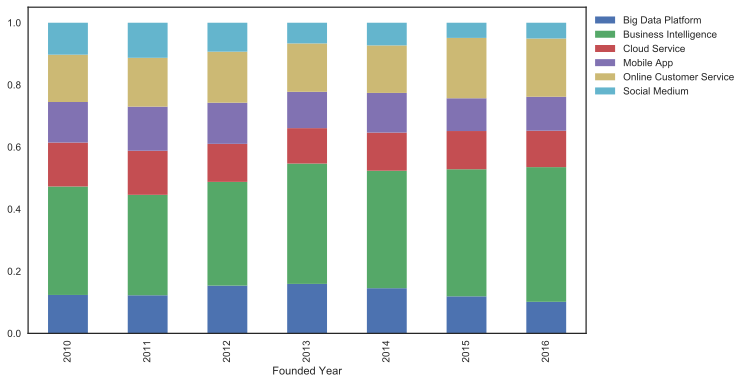

In [168]:
# percentage
df.div(df.sum(axis=1),axis=0).plot.bar(stacked=True).legend(bbox_to_anchor=(1, 1))

average funding in each area

In [170]:
# cb_data_merged_labeled['Total Funding Amount'] = cb_data_merged_labeled['Total Funding Amount'].str.replace(r'[$,]', '').astype(float)

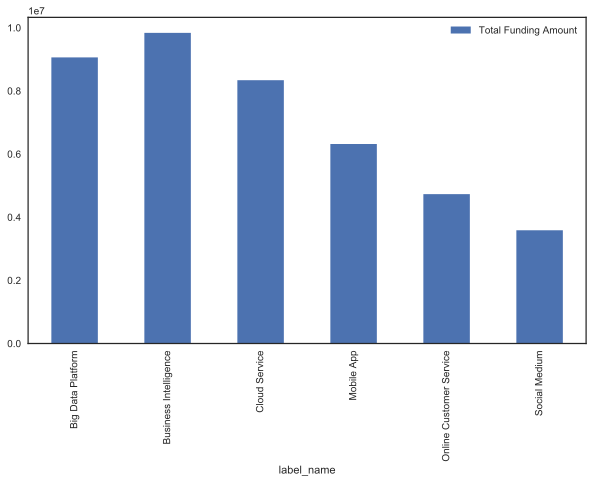

In [171]:
cb_data_merged_labeled.groupby('label_name').mean().plot.bar(y='Total Funding Amount')

In [172]:
cb_data_merged_labeled.groupby('label_name').describe()[['Total Funding Amount']].unstack()

Total Funding Amount                              \
                                       count          mean           std   
label_name                                                                 
Big Data Platform                      573.0  9.062385e+06  2.988937e+07   
Business Intelligence                 1221.0  9.838266e+06  5.919100e+07   
Cloud Service                          437.0  8.339062e+06  2.112720e+07   
Mobile App                             429.0  6.319936e+06  3.106077e+07   
Online Customer Service                665.0  4.731153e+06  1.267045e+07   
Social Medium                          255.0  3.586237e+06  9.240010e+06   

                                                                                
                             min       25%        50%        75%           max  
label_name                                                                      
Big Data Platform        10000.0  500000.0  2000000.0  6807327.0  5.700000e+08  
Business Intelligence     3000.0  230000.0  1200000.0  5000000.0  1.704000e+09  
Cloud Service             7500.0  354874.0  1500000.0  6250000.0  2.200000e+08  
Mobile App                5000.0  150000.0   651386.0  3572737.0  5.787000e+08  
Online Customer Service   1000.0  250000.0  1075000.0  3500000.0  2.000000e+08  
Social Medium             3500.0  163970.5   538062.0  2057700.0  7.200000e+07

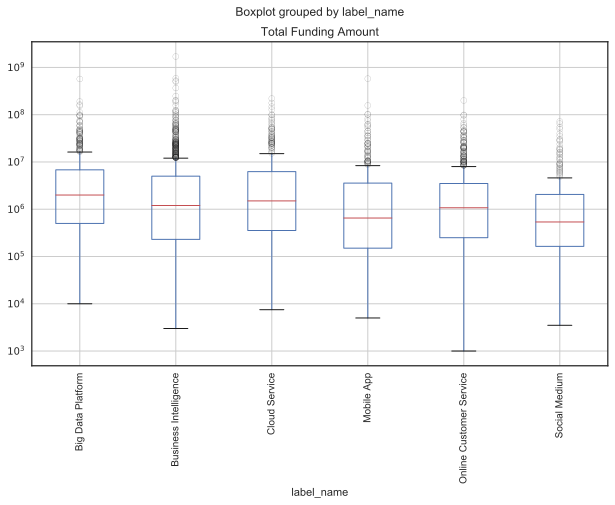

In [173]:
ax= cb_data_merged_labeled.boxplot(column='Total Funding Amount',by='label_name', rot=90)
ax.set_yscale('log')

In [92]:
max_idx=cb_data_merged_labeled['Total Funding Amount'].argmax()
print(cb_data_merged_labeled.iloc[max_idx])

Company Name                                                             Pivotal
Category Groups                  Data and Analytics, Software, Internet Services
Headquarters Location                       Palo Alto, California, United States
Description                    Pivotal is a software company that provides di...
Crunchbase Rank                                                              190
Founded Date                                                          2013-04-01
Number of Articles                                                          92.0
Total Equity Funding Amount                                       $1,704,000,000
Total Funding Amount                                                   1.704e+09
Closed Date                                                                  NaN
Categories                             Software, PaaS, Big Data, Cloud Computing
Status                                                                 Operating
Number of Founders          

percentage of acquisitions in each area

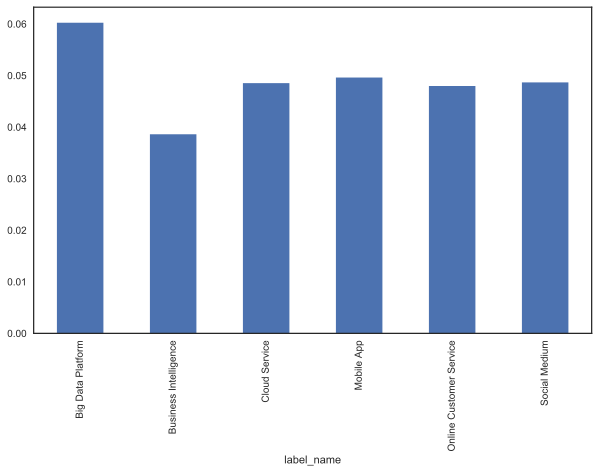

In [161]:
df = cb_data_merged_labeled.groupby('label_name').count()
(df['Acquired Year']/df['label']).plot.bar()

In [238]:
# Geo trend

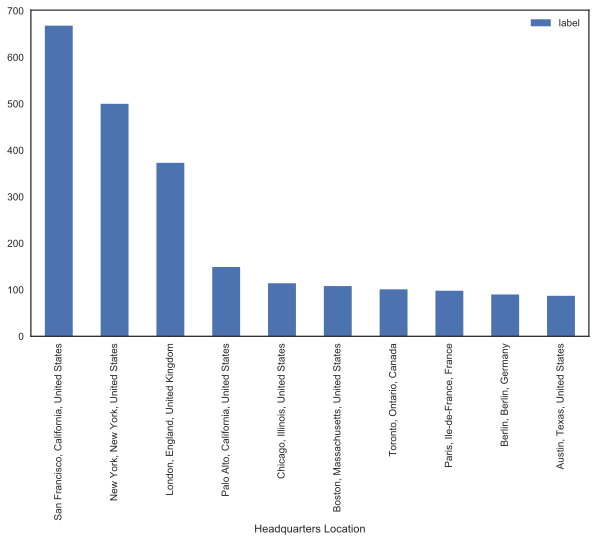

In [160]:
df = cb_data_merged_labeled.groupby(['Headquarters Location']).count()[['label']]
cities=df.sort_values(by='label', ascending=False).iloc[:10].index
df.loc[cities].plot.bar()

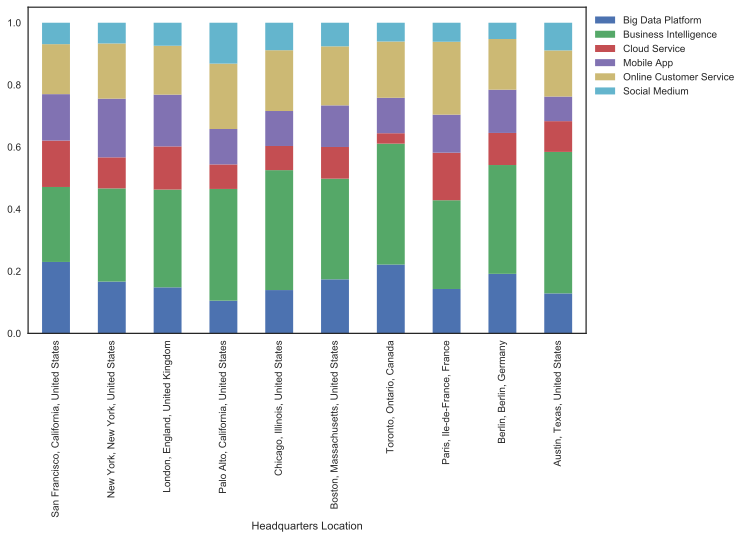

In [174]:
df = cb_data_merged_labeled[cb_data_merged_labeled['Headquarters Location'].isin(cities.tolist())]
df = df.groupby(['Headquarters Location','label_name']).count()['label'].unstack()
df.div(df.sum(axis=1),axis=0).plot.bar(stacked=True, x=cities).legend(bbox_to_anchor=(1, 1))

# A simple recommender 

In [175]:
from sklearn.neighbors import NearestNeighbors

In [179]:
neigh = NearestNeighbors(20, 0.4)
neigh.fit(topic_feature_norm) 

NearestNeighbors(algorithm='auto', leaf_size=30, metric='minkowski',
         metric_params=None, n_jobs=1, n_neighbors=20, p=2, radius=0.4)

In [180]:
cb_data_merged_labeled[cb_data_merged_labeled['Company Name']=='Krux'].index

Int64Index([0], dtype='int64')

In [207]:
def query_company(company_name, knn_model=neigh, data_set=cb_data_merged_labeled, X=topic_feature_norm):
    k=5
    pd.options.display.max_colwidth=300
    print(data_set[data_set['Company Name']==company_name]['google_description'])
    id=data_set[data_set['Company Name']==company_name].index
    print('-'*50)
    distances, indices = knn_model.kneighbors(X[id].reshape(1, -1),n_neighbors=k)
    for i in range(1,k):
        print('{}st neighbor: id {}, with distance {}'.format(i,indices[0][i],distances[0][i]))
        print(data_set.iloc[indices[0][i]]['Company Name'])
        print(data_set.iloc[indices[0][i]]['google_description'])
        print()

In [210]:
query_company('Datadog')

1    Datadog is the essential monitoring service for dynamic cloud infrastructure.Datadog is the essential monitoring service for dynamic cloud infrastructure.
Name: google_description, dtype: object
--------------------------------------------------
1st neighbor: id 2855, with distance 0.005216641846270149
Testivate
A cloud service that thoroughly benchmarks websites etc in days or hours at a fraction of the cost of engaging a consultantA cloud service that thoroughly benchmarks websites etc in days or hours at a fraction of the cost of engaging a consultant.

2st neighbor: id 4110, with distance 0.01073033082720218
RxAdvance
RxAdvance, a national full service PBM, leverages disruptive Collaborative PBM Cloud™ to manage standard & specialty drug benefits.RxAdvance, a national full service PBM, leverages disruptive Collaborative PBM Cloud™ to manage standard & specialty drug benefits.

3st neighbor: id 2337, with distance 0.024536640382643624
LANDR
LANDR is an audio post-production clo